In [1]:
!python -V

Python 3.11.7


In [2]:
import pandas as pd

In [3]:
import pickle

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error

In [6]:
df_jan = pd.read_parquet('./data/yellow_tripdata_2023-01.parquet')
df_feb = pd.read_parquet('./data/yellow_tripdata_2023-02.parquet')
print(len(list(df_jan)))
print(len(list(df_feb)))

19
19


In [7]:
df = df_jan


In [8]:
df['duration'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)
df.duration.std()

42.594351241920904

In [9]:
len(df)

3066766

In [10]:
df = df[(df.duration >= 1) & (df.duration <= 60)]

In [11]:
len(df)/3066766

0.9812202822125979

In [12]:
categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

df[categorical] = df[categorical].astype(str)

/tmp/ipykernel_110283/833933397.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[categorical] = df[categorical].astype(str)


In [13]:
train_dicts = df[categorical + numerical].to_dict(orient='records')
dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)
X_train.get_shape()

(3009173, 516)

In [14]:
# train_dicts = df[categorical + numerical].to_dict(orient='records')

# dv = DictVectorizer()
# X_train = dv.fit_transform(train_dicts)

target = 'duration'
y_train = df[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

mean_squared_error(y_train, y_pred, squared=False)

7.656752060138402

/tmp/ipykernel_110283/1672306066.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label='prediction')
/opt/anaconda/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/tmp/ipykernel_110283/1672306066.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function fo

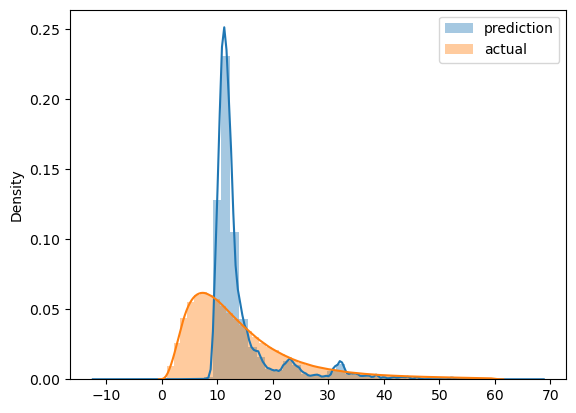

In [15]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()

In [16]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.tpep_dropoff_datetime = pd.to_datetime(df.tpep_dropoff_datetime)
        df.tpep_pickup_datetime = pd.to_datetime(df.tpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [17]:
df_train = read_dataframe('./data/yellow_tripdata_2023-01.parquet')
df_val = read_dataframe('./data/yellow_tripdata_2023-02.parquet')

In [18]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [19]:
categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [20]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [21]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

5.2472141744443705

In [22]:
# with open('models/lin_reg.bin', 'wb') as f_out:
#     pickle.dump((dv, lr), f_out)

In [23]:
lr = Lasso(0.01)
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)



In [24]:
mean_squared_error(y_val, y_pred, squared=False)

9.395699095576239